# HRTF representation learning and interpolation

Reference:

Zhang, Y., Wang, Y., & Duan, Z. (2023). [HRTF field: Unifying measured HRTF magnitude representation with neural fields.](https://ieeexplore.ieee.org/abstract/document/10095801) In Proc. IEEE International Conference on Acoustics, Speech and Signal Processing (ICASSP) (pp. 1-5). IEEE.

In [31]:
import numpy as np 
import matplotlib.pyplot as plt
import torch
import numpy as np
import librosa
import soundfile as sf
from scipy.signal import fftconvolve
import sofa
import os, glob
from mpl_toolkits.mplot3d import Axes3D
from torch import nn

from torch.utils.data import DataLoader, Dataset

## Implicit Neural Representation (Neural Field)

Implicit neural representation, also known as a neural field, is a method of representing discrete data with a continuous function. This approach uses a neural network to map input coordinates to output values, effectively creating a continuous representation of the data.

The function can be expressed as:

$$  f_\theta(\mathbf{x}) = \mathbf{y}  $$

where:
- $ f_\theta $ is the neural network parameterized by \(\theta\),
- $ \mathbf{x}$ is the input coordinate (e.g., spatial coordinates),
- $ \mathbf{y}$  is the output value (e.g., intensity, color, or any other property).

This allows for smooth interpolation and continuous representation of the data.

Reference lecture slides: [Link](https://www.cs.toronto.edu/~lindell/teaching/2529/2022/slides/lecture10.pdf)



## Introduction to Head-Related Transfer Function (HRTF)

Head-Related Transfer Function (HRTF) is a response that characterizes how an ear receives a sound from a point in space. It is a function that describes how the ear transforms sound waves arriving from different directions into the signals that are perceived by the brain. HRTFs are used to simulate how sounds are heard from different locations, which is crucial for creating realistic 3D audio experiences.

Key Points about HRTF:
* Spatial Filtering: HRTFs capture the effects of the head, torso, and outer ear (pinna) on the sound waves, which include reflections, diffractions, and absorptions.
* Directionality: HRTFs are direction-dependent, meaning they vary based on the azimuth (horizontal angle) and elevation (vertical angle) of the sound source relative to the listener.
* Frequency Response: HRTFs also vary with frequency, as different frequencies are affected differently by the shape and structure of the head and ears.

# Warm up on HRTF data

HRTFs are defined in the continuous space and describe how an ear receives a sound from a point in space. The HRTF can be expressed as a function of the direction of the sound source and the frequency of the sound.

The formula for HRTF is:

$$ H(\theta, \phi, f) $$

where:
- $ H $ is the HRTF,
- $ \theta $ is the azimuth angle (horizontal direction),
- $\phi$ is the elevation angle (vertical direction),
- $ f $ is the frequency of the sound.

This function captures the spatial filtering effects of the head, torso, and outer ear, providing a unique signature for each direction and frequency.

We first pick the HRTF of one individual and open the SOFA file containing the HRTF data.

For learning more about SOFA, visit https://www.sofaconventions.org/mediawiki/index.php/SOFA_(Spatially_Oriented_Format_for_Acoustics)

For learning more about analyzing SOFA file with Python, visit https://python-sofa.readthedocs.io/en/latest/


In [3]:
pp2_HRTF = sofa.Database.open('../data/HRIRs/pp2_HRIRs_measured.sofa')

Below, I plotted the source positions in 3D space. The x-axis represents the left-right position, the y-axis represents the front-back position, and the z-axis represents the up-down position. This shows all the source positions of HRTFs measured in this 3D3A dataset.

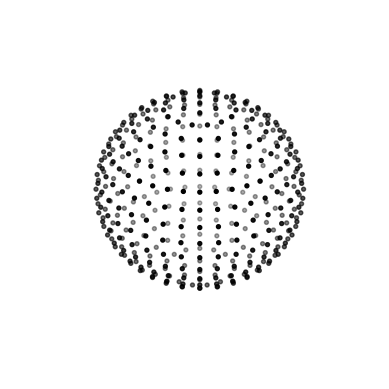

In [4]:
source_positions_cartesian = pp2_HRTF.Source.Position.get_values(system="cartesian")

# Unpack the coordinates for plotting
x, y, z = zip(*source_positions_cartesian)

# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Scatter plot
ax.scatter(x, y, z, s=8, c='k')

# Turn off the grid
ax.grid(False)
# Remove grid, tick labels, and axis
ax.grid(False)
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
ax.set_axis_off()

# # Remove the box around the plot
# ax.set_frame_on(False)

# Set equal aspect ratio for all axes to make the plot more spherical
scale_ratio = 0.88
max_range = np.array([np.max(np.abs(x)), np.max(np.abs(y)), np.max(np.abs(z))]).max()
ax.set_zlim(-max_range * scale_ratio, max_range * scale_ratio)

# Show the plot
plt.show()

## Fit a single person's HRTF with a neural field model

Representing HRTF with neural field

In [5]:
# Build a neural field

# a SIREN layer as in https://vsitzmann.github.io/siren/
class SirenLayer(nn.Module):
    def __init__(self, in_f, out_f, w0=30, is_first=False, is_last=False):
        super().__init__()
        self.in_f = in_f
        self.w0 = w0
        self.linear = nn.Linear(in_f, out_f)
        self.is_first = is_first
        self.is_last = is_last
        self.init_weights()

    def init_weights(self):
        b = 1 / self.in_f if self.is_first else np.sqrt(6 / self.in_f) / self.w0
        with torch.no_grad():
            self.linear.weight.uniform_(-b, b)

    def forward(self, x):
        x = self.linear(x)
        return x if self.is_last else torch.sin(self.w0 * x)


def build_model(dimensions):
    first_layer = SirenLayer(dimensions[0], dimensions[1], is_first=True)
    other_layers = []
    # other_layers.append(nn.LayerNorm(dimensions[1]))
    for dim0, dim1 in zip(dimensions[1:-2], dimensions[2:-1]):
        other_layers.append(SirenLayer(dim0, dim1))
        # other_layers.append(nn.LayerNorm(dim1))
    final_layer = SirenLayer(dimensions[-2], dimensions[-1], is_last=True)
    return nn.Sequential(first_layer, *other_layers, final_layer)

In [6]:
class HRTFField(nn.Module):
    def __init__(self, dimensions):
        super().__init__()
        self.net = build_model(dimensions)

    def forward(self, x):
        return self.net(x)

In [12]:
hrfr = np.abs(np.fft.fft(pp2_HRTF.Data.IR.get_values(), axis=-1))

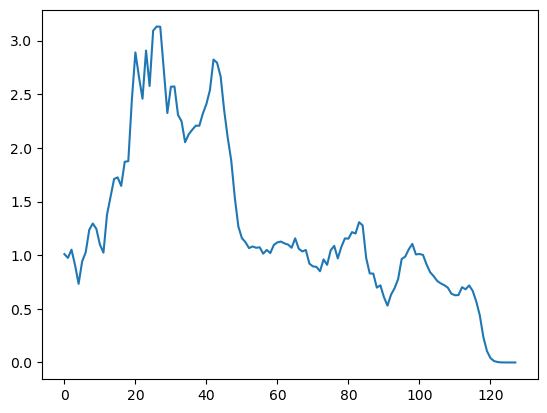

In [14]:
plt.plot(hrfr[0, 0, :128])

In [25]:
# Prepare the input data
source_positions_spherical = pp2_HRTF.Source.Position.get_values(system="spherical")

pp2_HRTF_HRIRs = pp2_HRTF.Data.IR.get_values()

pp2_HRTF_HRFRs = np.abs(np.fft.fft(pp2_HRTF_HRIRs, axis=-1))[:, 0, :128]


input_coordinates = torch.tensor(source_positions_spherical[:, :2], dtype=torch.float32)

output_data = torch.tensor(pp2_HRTF_HRFRs, dtype=torch.float32)

# Define the dimensions of the model
dimensions = [2, 256, 256, 128]  # Example dimensions, adjust as needed

# Initialize the HRTFField model
hrtf_field = HRTFField(dimensions)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(hrtf_field.parameters(), lr=1e-4 * 3)

# Training loop
num_epochs = 500  # Example number of epochs, adjust as needed
for epoch in range(num_epochs):
    optimizer.zero_grad()
    output = hrtf_field(input_coordinates)
    loss = criterion(output, output_data)  # Example loss, adjust as needed
    loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

# Save the trained model
torch.save(hrtf_field.state_dict(), 'hrtf_field_model.pth')

Epoch [100/500], Loss: 0.3951
Epoch [200/500], Loss: 0.2048
Epoch [300/500], Loss: 0.0942
Epoch [400/500], Loss: 0.0581
Epoch [500/500], Loss: 0.0379


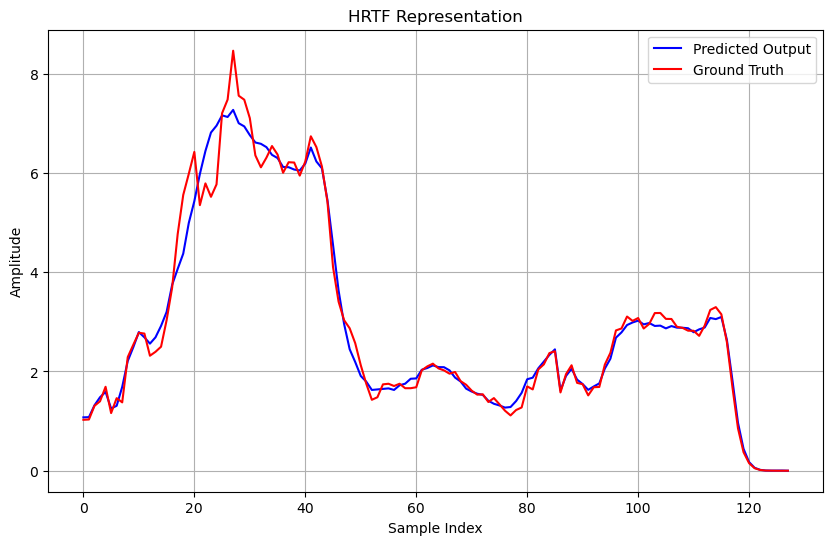

In [27]:
# Compare a single HRTF prediction with the ground truth

location_index = 100  # Example location index, adjust as needed

plt.figure(figsize=(10, 6))
plt.plot(output[location_index].detach().numpy(), color='blue', label='Predicted Output')
plt.plot(output_data[location_index].detach().numpy(), color='red', label='Ground Truth')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.title('HRTF Representation')
plt.legend()
plt.grid(True)
plt.show()

The training process is quite fast, and the field model can fit the data very well. With this trained neural network, we can now represent the HRTF as a continuous function. By inputting the coordinates, the model can predict the HRTF at those specific locations.

## A generative model to learn HRTF representation and perform interpolation

In [32]:
# data loader to load the HUTUBS HRTF data

class HUTUBS(Dataset):
    def __init__(self):
        super(HUTUBS, self).__init__()
        self.sofa_dir = os.path.join("../data/HRIRs")
        self.file_list = self._get_all_sofa_files_from_dir()

    def _get_all_sofa_files_from_dir(self):
        return glob.glob(os.path.join(self.sofa_dir, "*HRIRs_measured.sofa"))

    def _get_ID_from_sofa_path(self, path):
        return os.path.basename(path).split("_")[0][2:]

    def _get_sofa_path_from_ID(self, subject_ID):
        return os.path.join(self.sofa_dir, "pp%d_HRIRs_measured.sofa" % int(subject_ID))
    
    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self, idx):
        path = self.file_list[idx]
        sofa_file = sofa.Database.open(path)
        hrir = sofa_file.Data.IR.get_values()
        hrfr = np.abs(np.fft.fft(hrir, axis=-1))[:, 0, :128]
        source_positions = sofa_file.Source.Position.get_values(system="spherical")
        return torch.tensor(source_positions[:, :2], dtype=torch.float32), torch.tensor(hrfr, dtype=torch.float32)
    
hutubs = HUTUBS()

In [33]:
print(len(hutubs))
loc, hrfr = hutubs[0]
print(loc.shape, hrfr.shape)

96
torch.Size([440, 2]) torch.Size([440, 128])


In [ ]:
z_dim = 6
dimensions = [2+z_dim, 256, 256, 128]  # Example dimensions, adjust as needed


## A regression model to perform personalization based on anthropometric parameters

## Normalizing different spatial sampling schemes of different datasets 

## Extended Reading

Yutong Wen et al. WASPAA 2023

Yoshiki et al. ICASSP 2024

Thiago et al. EUSIPCO 2024
